# Supplemental Information:

> **"Clonal heterogeneity influences the fate of new adaptive mutations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 2 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figures 2 and S2 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# Load external dependencies
from setup import *
# Load internal dependencies
import config,plot,utils

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Data import

### Chromosome coordinates

In [2]:
chr_coords = utils.chr_coords()

chr_coords.head()

,chr_arabic,chr_length,chr_roman,chr_start,chr_end
0,1,230218,I,0,230218
1,2,813184,II,230218,1043402
2,3,316620,III,1043402,1360022
3,4,1531933,IV,1360022,2891955
4,5,576874,V,2891955,3468829


In [3]:
# Load data
freq_df = pd.read_csv(dir_data+'seq/background/seq_background_freq.csv.gz', encoding='utf-8', keep_default_na=False)

# Rearrange dataframe
freq_df = pd.pivot_table(
    freq_df, 
    index=['selection','sample','time'], 
    columns=['chr_arabic','chr_roman','pos','pos_cum'], 
    values='mean'
)

freq_df.head()

chr_arabic                            1                                       \
chr_roman                              I                                       
pos                               2718     2731     2734     4532     5035     
pos_cum                         2718     2731     2734     4532     5035       
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.926    0.926    0.926    0.948    0.944   
                           2       0.920    0.920    0.920    0.932    0.924   
                           4       0.931    0.931    0.931    0.948    0.951   
                           8       0.929    0.930    0.930    0.944    0.949   
                           16      0.956    0.957    0.957    0.969    0.960   

chr_arabic                                                                    \
chr_roman                                                                      
pos                               5218     5237     6556     6652     6673     
pos_cum                         5218     5237     6556     6652     6673       
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.942    0.942    0.921    0.921    0.921   
                           2       0.922    0.922    0.957    0.960    0.960   
                           4       0.948    0.948    0.954    0.954    0.955   
                           8       0.951    0.951    0.954    0.953    0.953   
                           16      0.956    0.956    0.965    0.967    0.968   

chr_arabic                        ...          16                             \
chr_roman                         ...         XVI                              
pos                               ...      924009   924127   924130   924152   
pos_cum                           ...    12047269 12047387 12047390 12047412   
selection sample           time   ...                                          
HU        WAxNA_F12_1_HU_1 0      ...       0.393    0.394    0.394    0.394   
                           2      ...       0.432    0.430    0.430    0.430   
                           4      ...       0.391    0.391    0.391    0.391   
                           8      ...       0.404    0.402    0.402    0.402   
                           16     ...       0.358    0.355    0.355    0.355   

chr_arabic                                                                    \
chr_roman                                                                      
pos                               924943   925012   925027   925033   926851   
pos_cum                         12048203 12048272 12048287 12048293 12050111   
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.412    0.414    0.415    0.415    0.428   
                           2       0.440    0.440    0.441    0.441    0.437   
                           4       0.394    0.394    0.394    0.394    0.409   
                           8       0.398    0.397    0.397    0.397    0.407   
                           16      0.360    0.361    0.361    0.361    0.376   

chr_arabic                                
chr_roman                                 
pos                               927911  
pos_cum                         12051171  
selection sample           time           
HU        WAxNA_F12_1_HU_1 0       0.428  
                           2       0.454  
                           4       0.414  
                           8       0.415  
                           16      0.382  

[5 rows x 52466 columns]

In [4]:
# Load data
seq_qtl_df = pd.read_csv(dir_data+'seq/background/seq_background_qtl_llh.csv.gz', encoding='utf-8', keep_default_na=False)

# Rearrange dataframe
seq_qtl_df = pd.pivot_table(
    seq_qtl_df, 
    index=['chr_arabic','chr_roman','pos','pos_cum'], 
    columns=['resolution','selection','sample'], 
    values='score'
)

seq_qtl_df.head()

resolution                                     2.0                    \
selection                                        RM                    
sample                             WAxNA_F12_1_RM_1 WAxNA_F12_1_RM_2   
chr_arabic chr_roman pos   pos_cum                                     
8          VIII      12938 4842868          4.74411         0.146892   
                     12985 4842915          4.73818         0.147830   
                     12997 4842927          4.73817         0.147831   
                     13185 4843115          5.15313         0.283097   
                     13408 4843338          5.10120         0.288338   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_1_RM_3 WAxNA_F12_1_RM_4   
chr_arabic chr_roman pos   pos_cum                                     
8          VIII      12938 4842868         0.077782         0.969071   
                     12985 4842915         0.077782         0.969076   
                     12997 4842927         0.080084         0.975848   
                     13185 4843115         0.067989         1.243700   
                     13408 4843338         0.074025         1.258580   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_2_RM_1 WAxNA_F12_2_RM_2   
chr_arabic chr_roman pos   pos_cum                                     
8          VIII      12938 4842868         0.020155         0.786893   
                     12985 4842915         0.020154         0.786894   
                     12997 4842927         0.020154         0.786893   
                     13185 4843115         0.012097         0.711532   
                     13408 4843338         0.012085         0.711693   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_2_RM_3 WAxNA_F12_2_RM_4   
chr_arabic chr_roman pos   pos_cum                                     
8          VIII      12938 4842868          5.78286         0.416840   
                     12985 4842915          5.78284         0.416847   
                     12997 4842927          5.78283         0.416840   
                     13185 4843115          4.34863         0.764097   
                     13408 4843338          4.30180         0.785666   

resolution                                                          \
selection                                                            
sample                             WAxNA_F2_1_RM_1 WAxNA_F2_1_RM_2   
chr_arabic chr_roman pos   pos_cum                                   
8          VIII      12938 4842868         1.35615         3.14470   
                     12985 4842915         1.35616         3.14470   
                     12997 4842927         1.35616         3.14470   
                     13185 4843115         1.73894         5.42792   
                     13408 4843338         1.74750         5.43454   

resolution                               ...                    50.0  \
selection                                ...                      RM   
sample                                   ...        WAxNA_F12_2_RM_2   
chr_arabic chr_roman pos   pos_cum       ...                           
8          VIII      12938 4842868       ...                0.957498   
                     12985 4842915       ...                0.912791   
                     12997 4842927       ...                0.912798   
                     13185 4843115       ...                0.999568   
                     13408 4843338       ...                0.943480   

resolution                                                            \
selection                                           

In [5]:
# Load data
seq_scores_df = pd.read_csv(dir_data+'seq/background/seq_background_qtl_scores.csv.gz', encoding='utf-8', keep_default_na=False)

# Rearrange dataframe
seq_scores_df = pd.pivot_table(
    seq_scores_df, 
    index=['chr_arabic','chr_roman','pos','pos_cum'], 
    columns=['resolution','selection'], 
    values='score'
)
    
seq_scores_df.head()

resolution                                2.0  5.0  10.0 30.0 50.0
selection                                   RM   RM   RM   RM   RM
chr_arabic chr_roman pos    pos_cum                               
8          VIII      454120 5284050  41.690200  NaN  NaN  NaN  NaN
                     454160 5284090  81.800000  NaN  NaN  NaN  NaN
                     454436 5284366  19.191600  NaN  NaN  NaN  NaN
                     454745 5284675   0.087844  NaN  NaN  NaN  NaN
                     455368 5285298  32.664115  NaN  NaN  NaN  NaN

In [6]:
# Load data
seq_mut_df = pd.read_csv(dir_data+'seq/de-novo/seq_de_novo_snv_indel.csv', encoding='utf-8', keep_default_na=False)

seq_mut_df = seq_mut_df[seq_mut_df.mutation_type=='driver']

# Remap genotypes
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'de novo'

seq_mut_df = pd.pivot_table(
    seq_mut_df, 
    index=['selection','population'], 
    columns=['chr_arabic','chr_roman','pos','pos_cum','gene']
)['frequency']

seq_mut_df.head()

chr_arabic                        7                             10            \
chr_roman                        VII                             X             
pos                         855961.0  856201.0  856202.0  392854.0  392864.0   
pos_cum                    4594951.0 4595191.0 4595192.0 6225315.0 6225325.0   
gene                            RNR4      RNR4      RNR4      RNR2      RNR2   
selection population                                                           
HU        NA_HU_1           0.078095  0.034108       NaN       NaN       NaN   
          NA_HU_2           0.098413  0.040323       NaN       NaN       NaN   
          WAxNA_F12_1_HU_1       NaN  0.126111  0.196517       NaN       NaN   
          WAxNA_F12_1_HU_2       NaN  0.952381       NaN       NaN       NaN   
          WAxNA_F12_1_HU_3       NaN       NaN       NaN       NaN       NaN   

chr_arabic                                                                    \
chr_roman                                                                      
pos                         392908.0  393020.0  565330.0  565331.0  565528.0   
pos_cum                    6225369.0 6225481.0 6397791.0 6397792.0 6397989.0   
gene                            RNR2      RNR2      TOR1      TOR1      TOR1   
selection population                                                           
HU        NA_HU_1                NaN       NaN       NaN       NaN       NaN   
          NA_HU_2                NaN       NaN       NaN       NaN       NaN   
          WAxNA_F12_1_HU_1       NaN       NaN       NaN       NaN       NaN   
          WAxNA_F12_1_HU_2       NaN       NaN       NaN       NaN       NaN   
          WAxNA_F12_1_HU_3   0.28502       NaN       NaN       NaN       NaN   

chr_arabic                                            14                      \
chr_roman                                            XIV                       
pos                         565529.0  565550.0  371921.0  372030.0  372195.0   
pos_cum                    6397990.0 6398011.0 9619557.0 9619666.0 9619831.0   
gene                            TOR1      TOR1      FPR1      FPR1      FPR1   
selection population                                                           
HU        NA_HU_1                NaN       NaN       NaN       NaN       NaN   
          NA_HU_2                NaN       NaN       NaN       NaN       NaN   
          WAxNA_F12_1_HU_1       NaN       NaN       NaN       NaN       NaN   
          WAxNA_F12_1_HU_2       NaN       NaN       NaN       NaN       NaN   
          WAxNA_F12_1_HU_3       NaN       NaN       NaN       NaN       NaN   

chr_arabic                            
chr_roman                             
pos                         372224.0  
pos_cum                    9619860.0  
gene                            FPR1  
selection population                  
HU        NA_HU_1                NaN  
          NA_HU_2                NaN  
          WAxNA_F12_1_HU_1       NaN  
          WAxNA_F12_1_HU_2       NaN  
          WAxNA_F12_1_HU_3       NaN

## Figure 2 - Genome-wide allele frequency changes

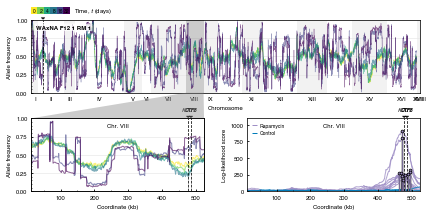

In [7]:
fig = plt.figure(figsize=(6, 5))

fig.subplots_adjust(left=0.05,bottom=0.05,right=0.95,top=0.9)

grid = gridspec.GridSpec(3, 1, height_ratios=[1.5,1,1], hspace=0.3)

gs = {}
gs['RM'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1])
gs['RM_zoom'] = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[2], wspace=0.25)

### Genome-wide allele frequency changes (top panel) ###
e = 'RM'
p = 'WAxNA_F12_1_RM_1'
    
ax1 = plt.subplot(gs[e][0])

data = freq_df.ix[(e,p)].T
times = data.columns.get_level_values('time')
colors = [config.time['color'][k] for k in times]
alpha = (0.6 if e in ['HU','RM'] else 0.9)
        
plot.gw_frequency(
    data.reset_index(), ax1, 
    x='pos_cum', y=times,
    color=colors, 
    alpha=alpha, 
    linewidth=0.4
)
    
ax1.set_xlabel('Chromosome')
ax1.set_ylabel('Allele frequency')
    
# Grid
xlabels = chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
ax1.set_xticks(xlabels)
ax1.set_xticklabels(chr_coords.chr_roman)
    
ax1.annotate(p.replace('_',' '),
             xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6, weight='bold',
             color='k', ha='left', va='center',
             xytext=(-5,0), textcoords='offset points', 
             bbox=(dict(facecolor='white', edgecolor='none', 
                        alpha=0.75, boxstyle='round,pad=.2', rasterized=False)))
    
# Show de novo mutations
data = seq_mut_df.ix[e,p].dropna(how='all')
    
labels = data.index.get_level_values('gene')
loc = zip(data.index.get_level_values('pos'), [1.01]*len(data))
    
for gene, (x, y) in zip(labels, loc):
    ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=2)
    ann = ax1.annotate(gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
                       xytext=(0, 8), textcoords='offset points',
                       arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                       fontsize=5, style='italic', weight='bold',
                       annotation_clip=False, va='center', ha='center')

# Legend
cax = inset_axes(
    ax1, width='10%', height='10%', loc=3,
    bbox_to_anchor=(0, 1.075, 1, 1), bbox_transform=ax1.transAxes, borderpad=0
)
mappable = plot.colorbar_index(ncolors=6, cmap=plt.cm.viridis_r) 
cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate(times):
    cbar.ax.text((j + .5)/ 6.0, .5, lab, ha='center', va='center', fontsize=5)
cbar.ax.yaxis.set_label_position("right")
cbar.ax.set_ylabel('Time, $t$ (days)', fontsize=5, rotation=0, ha='left', va='center')            
cbar.outline.set_visible(False)
        
### Zoomed inset (bottom left panel) ###
ax2 = plt.subplot(gs['RM_zoom'][0])
ax2_zoom = ax2.twiny()

# Draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
xmin = chr_coords[chr_coords.chr_arabic==8].chr_start.squeeze()
xmax = chr_coords[chr_coords.chr_arabic==8].chr_end.squeeze()

ax2_zoom.set_xlim(xmin, xmax)
ax2_zoom.set_xticks([])
ax2_zoom.set_xticklabels([])

plot.zoom_effect(ax1, ax2_zoom, xmin, xmax, edgecolor='none', facecolor='none', rasterized=False)

data = freq_df.loc[(e,p),8].T
times = data.columns.get_level_values('time')
colors = [config.time['color'][k] for k in times]
alpha = (0.6 if e in ['HU','RM'] else 0.9)
        
plot.chr_frequency(
    data.reset_index(), ax2, 
    x='pos', y=times,
    color=colors, 
    alpha=alpha, 
    linewidth=1
)

ax2.set_xlabel('Coordinate (kb)')
ax2.set_ylabel('Allele frequency')

ax2.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax2.xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12))

xticks = ax2.get_xticks()/1E3
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks.astype(int))

ax2.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax2.transAxes, fontsize=6,
             color='k', ha='center', va='center')

### Log-likelihood scores (bottom right panel) ###
ax3 = plt.subplot(gs['RM_zoom'][1], sharex=ax2)

# Slice chr. VIII at 30 kb resolution
llh = seq_qtl_df.loc[8,30]
colors = [config.selection['color'][e] for e in llh.columns.get_level_values('selection')]
llh.reset_index().plot(
    ax=ax3, kind='line',
    x='pos', y=['RM','YPD'],
    color=colors, alpha=0.8, lw=1,
    legend=False, rasterized=False, zorder=0
)

scores = seq_scores_df[30,'RM'].dropna()
markerline, stemlines, baseline = ax3.stem(scores.index.get_level_values('pos'), scores.values)
plt.setp(markerline, 'color', config.selection['color']['RM'],
         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
plt.setp(stemlines, linewidth=.75, color=config.selection['color']['RM'],
         path_effects=[path_effects.withStroke(linewidth=1.25, foreground="k")], zorder=2)  
plt.setp(baseline, 'color', 'none', zorder=1)

ax3.set_xlabel('Coordinate (kb)')
ax3.set_ylabel('Log-likelihood score')

# Axes limits
ax3.set_ylim(0, 1.1E3)
ax3.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax3.xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12))
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax3.yaxis.set_ticks_position('left')

# Annotation in chromosome coordinates
annotation = {
    'CTF8': {
        'chr': 8,
        'start': 486230,
        'end': 486631
    },
    'KOG1': {
        'chr': 8,
        'start': 475999,
        'end': 480672       
    }
}

RM_artist = lines.Line2D((0,1),(0,0), color=config.selection['color']['RM'], linewidth=1)
YPD_artist = lines.Line2D((0,1),(0,0), color=config.selection['color']['YPD'], linewidth=1)

leg3 = ax3.legend([RM_artist,YPD_artist],
                  ['Rapamycin','Control'], ncol=1,
                  frameon=False, loc='upper left',
                  borderaxespad=0.5, handlelength=1, 
                  prop={'size': 5})
plt.setp(leg3.get_title(), fontsize=6)

ax3.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax3.transAxes, fontsize=6,
             color='k', ha='center', va='center')

for ax in [ax2,ax3]:
    
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
    for gene in annotation:
        x = annotation[gene]['start'] + (annotation[gene]['end'] - annotation[gene]['start'])/2
        y = 1.01
        ax.axvline(x=x, c='k', ls="--", lw=.75, zorder=2)
        ann = ax.annotate(
            gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
            xytext=(0, 8), textcoords='offset points',
            arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
            fontsize=5, style='italic', weight=('bold' if gene=='CTF8' else 'normal'),
            annotation_clip=False, va='center', ha='center'
        )

for ax in fig.get_axes():
    # Axis label size
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    # Spine properties
    for spine in ax.spines.values():
        spine.set(color='k', linewidth=0.75, linestyle='-')

plot.save_figure(dir_paper+'figures/figure2/figure2')
plt.show()

**Fig. 2:** Study overview and genome-wide allele frequency changes. (**A**) Schematic diagram of the divergence, crossing and selection phases of the experiment. Two diverged parental lines of *S. cerevisiae* were crossed for twelve rounds, generating a large ancestral population of unique haplotypes. These diploid cells were asexually evolved for 32 days in stress and control environments and the resulting adaptation was studied by whole-population and isolate sequencing and phenotyping. Populations evolved resistant macroscopic subclones driven by beneficial *de novo* mutations and individuals whose parental allele configurations, i.e. genetic backgrounds, provided a resistance phenotype. (**B**) Genome-wide allele frequency  of pre-existing parental variants as observed for a representative population in rapamycin (WAxNA F12 1 RM 1). Bottom left: Zoomed inset of the shaded region shows allele frequency changes in chromosome VIII during selection in rapamycin. Early time points 2, 4 and 8 show localized allele frequency changes at 460-490 kb due to a beneficial NA allele sweeping with hitchhiking passengers. Late time points 16 and 32 show abrupt jumps between successive loci that reflect the parental haplotype of the emerging subclone(s). These long-range correlations can alter the frequency of parental alleles independently of their fitness value. In case of a fully clonal population, the allele frequencies would be at 0, 0.5 and 1.0 corresponding to the background loci genotypes NA/NA, WA/NA, and WA/WA of a diploid clone that reached fixation. Bottom right: We tested a model where each allele is proposed to be a driver under selection thus changing in frequency and causing movement in nearby linked passenger alleles. Top log-likelihood scores are shown for all populations in this region of interest (Supplemental Experimental Procedures). We validated the *CTF8* NA allele to be strongly beneficial for rapamycin resistance (Fig. S8).

## Figure S2 - Genome-wide allele frequency changes

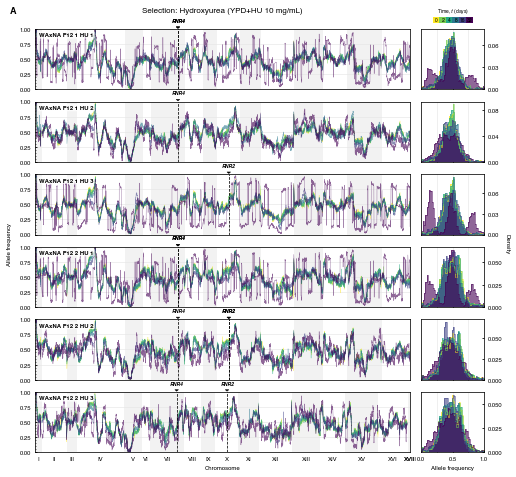

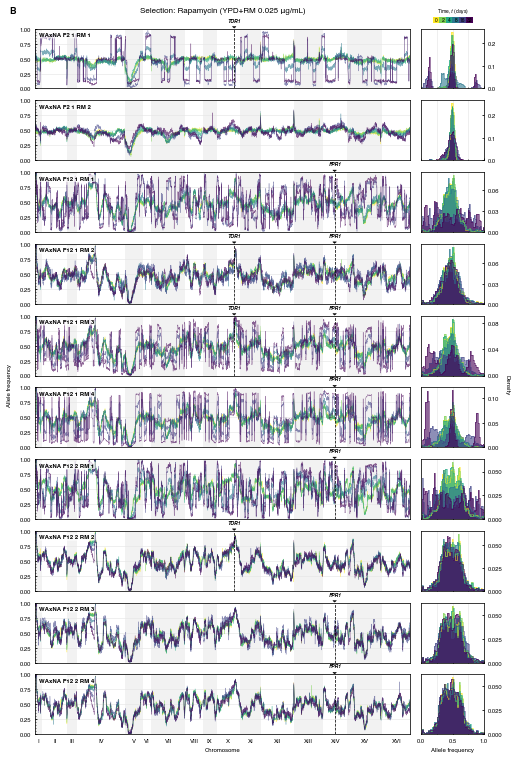

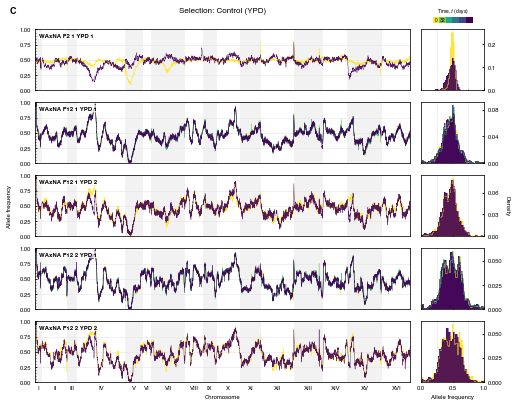

In [8]:
panels = {
    'HU': {
        'WAxNA_F12_1_HU_1':0, 
        'WAxNA_F12_1_HU_2':1, 
        'WAxNA_F12_1_HU_3':2, 
        'WAxNA_F12_2_HU_1':3, 
        'WAxNA_F12_2_HU_2':4,
        'WAxNA_F12_2_HU_3':5
        },
    'RM': {
        'WAxNA_F2_1_RM_1':0,
        'WAxNA_F2_1_RM_2':1,
        'WAxNA_F12_1_RM_1':2, 
        'WAxNA_F12_1_RM_2':3, 
        'WAxNA_F12_1_RM_3':4, 
        'WAxNA_F12_1_RM_4':5,
        'WAxNA_F12_2_RM_1':6, 
        'WAxNA_F12_2_RM_2':7, 
        'WAxNA_F12_2_RM_3':8, 
        'WAxNA_F12_2_RM_4':9   
    },
    'YPD': {
        'WAxNA_F2_1_YPD_1':0,
        'WAxNA_F12_1_YPD_1':1, 
        'WAxNA_F12_1_YPD_2':2, 
        'WAxNA_F12_2_YPD_1':3, 
        'WAxNA_F12_2_YPD_2':4
    }
}

freq_df = freq_df.ix[['HU','RM','YPD']]

shape = pd.DataFrame({k: x.shape for k,x in freq_df.unstack('time').groupby(level=['selection'])})

ygrid = shape.loc[0,['HU','RM','YPD']].values

gs = {}

for ii, (e, sdf) in enumerate(freq_df.groupby(level='selection')):
    
    nrows = len(sdf.index.get_level_values('sample').unique())
    ncols = 2
            
    height, width = np.array([nrows, ncols*4], dtype=float)
    
    fig = plt.figure(figsize=(width, height))
    
    fig.subplots_adjust(left=0.07,bottom=0.01,right=0.85,top=0.99)
    
    gs[e] = gridspec.GridSpec(nrows, ncols, width_ratios=[6, 1], hspace=0.2, wspace=0.05)

    for (jj, (p, data)) in enumerate(sdf.groupby(level='sample')):
        
        # Retrieve axes
        if jj==0:
            ax1 = plt.subplot(gs[e][panels[e][p],0])
            ax2 = plt.subplot(gs[e][panels[e][p],1])
        else:
            ax1 = plt.subplot(gs[e][panels[e][p],0], sharex=ax1)
            ax2 = plt.subplot(gs[e][panels[e][p],1], sharex=ax2)
        
        data = freq_df.ix[(e,p)].T
        times = data.columns.get_level_values('time')
        colors = [config.time['color'][k] for k in times]
        alpha = (0.6 if e in ['HU','RM'] else 0.9)
        
        plot.gw_frequency(
            data.reset_index(), ax1, 
            x='pos_cum', y=times,
            color=colors, 
            alpha=alpha, 
            linewidth=0.4
        )
        plot.histogram_frequency(
            data, ax2, 
            alpha=alpha
        )
        
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4'),('YPD','WAxNA_F12_2_YPD_2')]:
            ax1.set_xlabel('Chromosome')
            ax2.set_xlabel('Allele frequency')
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_3'),('YPD','WAxNA_F12_1_YPD_2')]:
            xy = {'HU':(-.06, -.15),'RM':(-.06, -.15),'YPD':(-.06, .5)}
            ax1.annotate(
                'Allele frequency', xy=xy[e], xycoords=ax1.transAxes,
                color='k', fontsize=6, ha='right', va='center', rotation=90,
                xytext=(0, 0), textcoords='offset points'
            )
            xy = {'HU':(1.4, -.15),'RM':(1.4, -.15),'YPD':(1.4, .5)}
            ax2.annotate(
                'Density', xy=xy[e], xycoords=ax2.transAxes,
                color='k', fontsize=6, ha='right', va='center', rotation=270,
                xytext=(0, 0), textcoords='offset points'
            )
            
        # Set panel labels
        if ax1.is_first_row():
            ax1.text(-0.05, 1.3, chr(ii + ord('A')), transform=ax1.transAxes,
                     fontsize=9, fontweight='bold', va='center', ha='right')
            ax1.text(0.5, 1.3, 'Selection: %s' % config.selection['long_label'][e], 
                     transform=ax1.transAxes, fontsize=8, va='center', ha='center')
        
        # Set population label
        ax1.annotate(
            p.replace('_',' '),
            xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6,
            color='k', weight='bold', ha='left', va='center',
            xytext=(-5,0), textcoords='offset points', 
            bbox=(dict(facecolor='white', edgecolor='none', alpha=0.75, boxstyle='round,pad=.2'))
        )
        
        # Draw chromosome labels
        if ax1.is_last_row():
            xlabels=chr_coords.chr_start + (chr_coords.chr_end - chr_coords.chr_start)/2.
            ax1.set_xticks(xlabels)
            ax1.set_xticklabels(chr_coords.chr_roman)
        
        # Draw legend
        if ax1.is_first_row():
            cax = inset_axes(
                ax2, width='80%', height='10%', loc=8,
                bbox_to_anchor=(0.1, 1.1, 0.8, 1), bbox_transform=ax2.transAxes, borderpad=0
            )
            mappable = plot.colorbar_index(ncolors=6, cmap=plt.cm.viridis_r) 
            cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
            cbar.ax.get_xaxis().set_ticks([])
            for jj, label in enumerate(times):
                cbar.ax.text((jj + .5)/ 6.0, .5, label, ha='center', va='center', fontsize=5)
            cbar.ax.set_title('Time, $t$ (days)', fontsize=5, ha='center', va='center')            
            cbar.outline.set_visible(False)
            
        # Fix axes ticks
        ax1.tick_params(axis='x', which='minor', size=0)
                    
        # Show de novo mutations
        if (e,p) in seq_mut_df.index:
        
            data = seq_mut_df.ix[e,p].dropna(how='all')
                
            labels = data.index.get_level_values('gene')
            loc = zip(data.index.get_level_values('pos_cum'), [1.01]*len(data))
    
            for gene, (x,y) in zip(labels, loc):
                ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=3)
                ann = ax1.annotate(
                    gene, xy=(x,y), xycoords=('data', 'axes fraction'), 
                    xytext=(0, 8), textcoords='offset points',
                    arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                    fontsize=5, style='italic', weight='bold',
                    va='center', ha='center'
                )
    
    for ax in fig.get_axes():
        # Axis label size
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        # Spine properties
        for spine in ax.spines.values():
            spine.set(color='k', linewidth=0.75, linestyle='-')

    plot.save_figure(dir_supp+'figures/supp_figure_seq_allele_freqs/supp_figure_seq_allele_freqs_%s' % e, dpi=150)
    plt.show()

**Fig. S2:** Time series of genome-wide frequencies, $x_i^\text{WA}$, of the WA allele after ${t\,{=}\,\text{(0, 2, 4, 8, 16, 32)}}$ days, measured by whole-population sequencing. From top to bottom, replicate populations were evolved in (**A**) hydroxyurea, (**B**) rapamycin and (**C**) a control environment. Allele frequencies are estimated from the mean posterior probability given by the filterHD algorithm. Left: Chromosomes are ordered along the $x$-axis; allele frequencies of 52,466 background variants are shown on the $y$-axis, colored by time point. Driver mutations are highlighted by arrows. Right: Changes in the allele frequency spectrum across time.